In [1]:
import os
import re
import pdb
import torch
import logging
import numpy as np

import torch.nn.functional as F

from tqdm import tqdm, trange
from glob import glob
from mylogger import get_mylogger
from image_specific_attack import create_model

In [4]:
def load_image(image_path: str):
    filename = glob(image_path+"*.pth")
    adv_examples = []
    labels = []
    for file in tqdm(filename[0:1000]):
        adv_example = torch.load(file)
        adv_examples.append(adv_example)

        label = int(re.split('_|\.', file)[-2])
        labels.append(label)

    return adv_examples, labels
    

In [3]:
# log_path = "./log/detect"
# os.makedirs(log_path, exist_ok=True)
# logger = get_mylogger(log_path)

patch_size = 7
model = create_model(
    'ResNet18', './result/models/ResNet18_{}/model_best.pth.tar'.format(patch_size)).eval()

adv_example_path = 'result/attack/image_specific/ResNet18/ResNet18_{}/patched/'.format(
    patch_size)
adv_examples, labels = load_image(adv_example_path)

=> creating model 
100%|██████████| 1000/1000 [00:06<00:00, 159.53it/s]


In [5]:
def compute_normal_acc(model, adv_examples, labels):
    normal_acc = 0
    for i in trange(len(adv_examples)):
        adv_example = adv_examples[i]
        label = labels[i]

        adv_out = F.log_softmax(model(adv_example), dim=1)
        adv_out_probs, adv_out_labels = adv_out.max(1)
        # have already set the target label to 5.
        if adv_out_labels == label:
            normal_acc += 1
    print("\nnormal acc: ", normal_acc/len(adv_examples))

def compute_attack_acc(model, adv_examples, labels):
    attack_acc = 0
    for i in trange(len(adv_examples)):
        adv_example = adv_examples[i]
        label = labels[i]

        adv_out = F.log_softmax(model(adv_example), dim=1)
        adv_out_probs, adv_out_labels = adv_out.max(1)
        # have already set the target label to 5.
        if adv_out_labels == 5:
            attack_acc += 1
    print("\nattack acc: ", attack_acc/len(adv_examples))

In [6]:
compute_normal_acc(model, adv_examples, labels)

100%|██████████| 1000/1000 [00:06<00:00, 157.29it/s]
normal acc:  0.397



In [44]:
def detect_patch(model, adv_example):
    output = model.module.conv1(adv_example)
    output = output.sum(axis = 1)
    topk = 115
    tmp_output = output.reshape(-1)
    topk_value = tmp_output[torch.topk(tmp_output,topk)[1][-1]]
    tmp_output = torch.relu(torch.sign(output-topk_value))
    all_one_conv = torch.nn.Conv2d(1,1,7)
    all_one_conv.weight.data = torch.ones((1,1,7,7))
    all_one_conv.bias.data = torch.zeros(1) 
    a = all_one_conv(tmp_output.unsqueeze(0).to(torch.device('cpu')))
    return a

In [59]:
import matplotlib.pyplot as plt
%inline matplotlib

UsageError: Line magic function `%inline` not found.


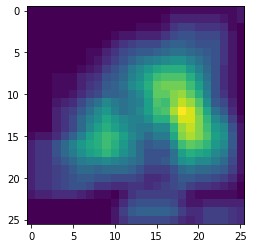

In [92]:
a = detect_patch(model, adv_examples[13])
plt.imshow(a.squeeze(0).squeeze(0).detach().numpy())

In [93]:
clean_example_path = 'result/attack/image_specific/ResNet18/ResNet18_{}/ori/'.format(
    patch_size)
clean_examples, labels = load_image(clean_example_path)


100%|██████████| 1000/1000 [00:01<00:00, 634.19it/s]


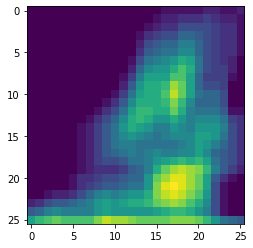

In [86]:
a = detect_patch(model, clean_examples[19])
plt.imshow(a.squeeze(0).squeeze(0).detach().numpy())